In [1]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torch.nn.functional as F

!pip install torcheval
import torcheval

import tqdm

import os
import warnings

from sklearn.metrics import f1_score

from pytorch_lightning import seed_everything
seed_everything(1)

%matplotlib inline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import math

def plot_losses(train_losses, smoothing=0.1, figsize=(12, 6)):
    """
    Plot losses with a smoothed line and individual points.
    
    Parameters:
    -----------
    train_losses : list or array-like
        Training loss values
    val_losses : list or array-like, optional
        Validation loss values
    smoothing : float, default=0.1
        Exponential moving average smoothing factor (0 to 1)
    figsize : tuple, default=(12, 6)
        Figure size (width, height)
    """
    
    def smooth(y, factor):
        """Calculate exponential moving average"""
        smoothed = []
        last = y[0]
        for point in y:
            smoothed_val = last * (1 - factor) + point * factor
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed
    
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Convert losses to numpy arrays
    train_losses = np.array(train_losses)
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Plot training losses
    
    plt.plot(epochs, train_losses, 'b.', alpha=0.3, label='Loss')
    plt.plot(epochs, smooth(train_losses, smoothing), 'cyan', linewidth=2, label='Smoothed Loss')
    
    # Customize plot
    plt.grid(True, alpha=0.3)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Model loss History')
    plt.legend()
    
    # Show min/max values
    min_train = train_losses.min()
    max_train = train_losses.max()
    
    stats = pd.DataFrame({
        'Metric': ['Training Loss'],
        'Minimum': [f'{min_train:.6f}'],
        'Maximum': [f'{max_train:.6f}'],
        'Final': [f'{train_losses[-1]:.6f}']
    })
    
    # Show plot and statistics
    plt.show()
    display(HTML(stats.to_html(index=False)))


def plot_metrics(train_metrics, smoothing=0.1, figsize=(15, 8)):
    """
    Plot multiple training (and validation) metrics over time.
    
    Parameters:
    -----------
    train_metrics : dict
        Dictionary of training metrics, where keys are metric names and values are lists of metric values
    val_metrics : dict, optional
        Dictionary of validation metrics with the same structure as train_metrics
    smoothing : float, default=0.1
        Exponential moving average smoothing factor (0 to 1)
    figsize : tuple, default=(15, 8)
        Base figure size (width, height) - will be adjusted based on number of metrics
    """
    def smooth(y, factor):
        smoothed = []
        last = y[0]
        for point in y:
            smoothed_val = last * (1 - factor) + point * factor
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed
    
    # Calculate grid layout
    n_metrics = len(train_metrics)
    n_cols = min(3, n_metrics)
    n_rows = math.ceil(n_metrics / n_cols)
    
    # Adjust figure size based on number of subplots
    adjusted_figsize = (figsize[0], figsize[1] * n_rows / 2)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=adjusted_figsize)
    if n_metrics == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Prepare statistics table
    stats_data = []
    
    # Plot each metric
    for idx, (metric_name, train_values) in enumerate(train_metrics.items()):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        train_values = np.array(train_values)
        train_epochs = np.arange(1, len(train_values) + 1)
        
        # Plot training metrics
        ax.plot(train_epochs, train_values, 'b.', alpha=0.3, label='metrics')
        ax.plot(train_epochs, smooth(train_values, smoothing), 'cyan', 
                linewidth=2, label='Smoothed metrics')
        
        # Add training stats
        stats_data.append({
            'Metric': f'Train {metric_name}',
            'Minimum': f'{train_values.min():.4f}',
            'Maximum': f'{train_values.max():.4f}',
            'Final': f'{train_values[-1]:.4f}'
        })
        
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Iteration')
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} History')
        ax.legend()
    
    # Remove empty subplots
    for idx in range(n_metrics, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()
    
    # Display statistics table
    stats_df = pd.DataFrame(stats_data)
    display(HTML(stats_df.to_html(index=False)))

In [3]:
dataset = ImageFolder(
    "/kaggle/input/one-piece-classification/splitted/train",
    transform=v2.Compose(
        [
            v2.Resize((128, 128)),
            v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
)

generator = torch.Generator().manual_seed(7)
train_set, val_set = torch.utils.data.random_split(
    dataset, [0.999,0.001],
    generator
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)

print(len(train_dataloader))
print(len(val_dataloader))

183
1


In [4]:
import json 
lables = json.load(open("/kaggle/input/one-piece-classification/labels.json", "r"))
print(lables)

{'0': 'Ace', '1': 'Akainu', '2': 'Brook', '3': 'Chopper', '4': 'Crocodile', '5': 'Franky', '6': 'Jinbei', '7': 'Kurohige', '8': 'Law', '9': 'Luffy', '10': 'Mihawk', '11': 'Nami', '12': 'Rayleigh', '13': 'Robin', '14': 'Sanji', '15': 'Shanks', '16': 'Usopp', '17': 'Zoro'}


torch.Size([3, 128, 128])


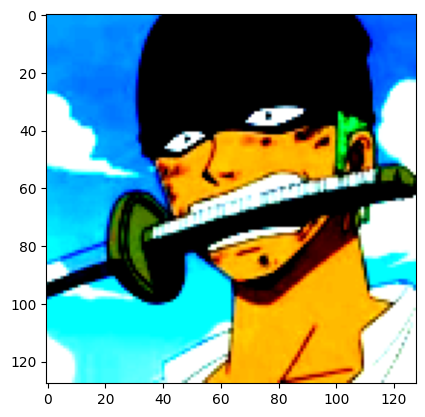

In [5]:
img = dataset[-1][0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [6]:
class ResBlock(nn.Module):
    """Residual block with skip"""
    def __init__(self, in_channels, out_channels, stride=1, kernel_size = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        

In [7]:
class Net(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 18):
        super().__init__()
        self.in_ch = in_channels
        self.starter_block = ResBlock(self.in_ch, 64, kernel_size = 7)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.block = ResBlock(64, 90)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.base1 = nn.Sequential(ResBlock(90, 256)) 

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

            
    def forward(self, x):
        x = self.starter_block(x)
        x = self.pool1(x)
        x = self.block(x)
        x = self.pool2(x)
        x = self.base1(x)
        
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

In [8]:
model = Net()

In [9]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [10]:
from collections import namedtuple

LossInfo = namedtuple(
    "LossInfo", ["all_train_losses", "all_train_metrics", "epoch_train_losses", "all_eval_losses", "all_eval_metrics", "epoch_eval_losses"]
)

In [11]:
from torcheval.metrics import MulticlassF1Score
from sklearn.metrics import f1_score
metrics = {"f1":MulticlassF1Score()}

In [12]:
transform = v2.Compose([v2.RandomResizedCrop(128, scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(15),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),])

In [13]:
def train_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    transform,
    criterion: nn.Module,
    metrics, 
    optimizer: torch.optim.Optimizer,
    binary: int | None = None,
    device:str = "cuda:0"
):
    model = model.train()
    num_batches = 0
    total_f1 = 0
    all_losses = []
    all_metrics = []
    model.train()
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            preds = model(inputs)
            loss = criterion(preds, targets.to(torch.int64))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            # metrics["f1"].update(preds.argmax(1), targets)
            m = f1_score(targets.to("cpu"), preds.argmax(1).to("cpu"), average="micro")
            all_metrics.append(m)
            total_f1 += m
            metrics_desc = f", f1: {m}"
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} " + metrics_desc
            )
            prbar.update(1)
            num_batches += 1
            all_losses.append(loss.detach().item())
            del inputs
            del preds
            del loss
            del targets
    metric_values = {"f1":total_f1/len(data_loader)}
    return metric_values, all_losses, {"f1":all_metrics}


In [14]:
def validate(
        model: nn.Module,
        data_loader: torch.utils.data.DataLoader,
        criterion: nn.Module,
        metrics,
        binary: bool | None = None,
        device: str = "cuda:0"):
    model = model.eval()
    total_f1 = 0
    num_batches = 0
    all_losses = []
    all_metrics = []
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            with torch.no_grad():
                model.eval()
                preds = model(inputs)
                loss = criterion(preds, targets)
            all_losses.append(loss.detach().item())
            # metrics["f1"].update(preds.argmax(1), targets)
            m = f1_score(targets.to("cpu"), preds.argmax(1).to("cpu"), average="micro")
            all_metrics.append(m)
            total_f1 += m
            metrics_desc = f", f1: {m}"
            prbar.set_description(
                f"Loss: {loss.item():.4} " + metrics_desc
            )
            prbar.update(1)
            del inputs
            del preds
            del loss
            del targets
            
            num_batches += 1
        metric_values = {"f1":total_f1/len(data_loader)}
    return metric_values, all_losses, {"f1":all_metrics}

In [15]:
def train(
    model,
    epochs,
    train_data_loader,
    train_transform,
    validation_data_loader,
    criterion,
    metrics,
    optimizer,
    scheduler=None,
    device ="cuda:0",
):
    all_train_losses = []
    all_train_metrics = {"f1":[]}
    all_eval_losses = []
    all_eval_metrics = {"f1":[]}
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses, one_epoch_train_metrics = train_epoch(
            model=model,
            data_loader=train_iterator,
            transform= train_transform,
            criterion=criterion,
            metrics=metrics,
            optimizer=optimizer,
            device = device,
        )
        all_train_losses.extend(one_epoch_train_losses)
        all_train_metrics["f1"].extend(one_epoch_train_metrics["f1"])
        epoch_train_losses.append(train_metrics)
        print(f"Validation Epoch: {epoch}")
        eval_metrics, one_epoch_eval_losses, one_epoch_eval_metrics  = validate(
            model=model, 
            data_loader=validation_iterator,
            criterion=criterion,
            metrics=metrics,
            device = device,)
        all_eval_losses.extend(one_epoch_eval_losses)
        all_eval_metrics["f1"].extend(one_epoch_eval_metrics["f1"])
        epoch_eval_losses.append(eval_metrics)
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, all_train_metrics, epoch_train_losses, all_eval_losses, all_eval_metrics, epoch_eval_losses)

In [16]:
EPOCHS = 60
LR = 0.001

In [17]:
import tqdm

model.to(device)
_ = train(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    train_transform=transform,
    validation_data_loader=val_dataloader,
    criterion=loss,
    metrics=metrics,
    optimizer=torch.optim.AdamW(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0


Loss: 2.9708 , f1: 0.0: 100%|██████████| 183/183 [01:14<00:00,  2.46it/s]   


Validation Epoch: 0


Loss: 1.934 , f1: 0.0: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Train Epoch: 1


Loss: 2.9713 , f1: 0.0: 100%|██████████| 183/183 [00:51<00:00,  3.53it/s]   


Validation Epoch: 1


Loss: 1.546 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


Train Epoch: 2


Loss: 2.593 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.80it/s]    


Validation Epoch: 2


Loss: 1.472 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Train Epoch: 3


Loss: 3.5778 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.80it/s]   


Validation Epoch: 3


Loss: 0.9857 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Train Epoch: 4


Loss: 2.8865 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.82it/s]   


Validation Epoch: 4


Loss: 1.205 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Train Epoch: 5


Loss: 3.3968 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]   


Validation Epoch: 5


Loss: 0.9235 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Train Epoch: 6


Loss: 2.4089 , f1: 0.0: 100%|██████████| 183/183 [00:51<00:00,  3.54it/s]   


Validation Epoch: 6


Loss: 0.6221 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


Train Epoch: 7


Loss: 1.6991 , f1: 1.0: 100%|██████████| 183/183 [00:52<00:00,  3.51it/s]   


Validation Epoch: 7


Loss: 0.416 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Train Epoch: 8


Loss: 3.0986 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.75it/s]   


Validation Epoch: 8


Loss: 0.4221 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Train Epoch: 9


Loss: 2.7859 , f1: 0.0: 100%|██████████| 183/183 [00:49<00:00,  3.70it/s]   


Validation Epoch: 9


Loss: 0.5517 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Train Epoch: 10


Loss: 3.9487 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]   


Validation Epoch: 10


Loss: 0.5882 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Train Epoch: 11


Loss: 3.1672 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 11


Loss: 0.6116 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Train Epoch: 12


Loss: 3.1686 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.82it/s]   


Validation Epoch: 12


Loss: 0.4866 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Train Epoch: 13


Loss: 2.7106 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.81it/s]   


Validation Epoch: 13


Loss: 0.2089 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Train Epoch: 14


Loss: 2.9926 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]   


Validation Epoch: 14


Loss: 0.4538 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Train Epoch: 15


Loss: 3.3261 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]   


Validation Epoch: 15


Loss: 0.1086 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Train Epoch: 16


Loss: 2.3496 , f1: 1.0: 100%|██████████| 183/183 [00:48<00:00,  3.79it/s]   


Validation Epoch: 16


Loss: 0.4123 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Train Epoch: 17


Loss: 3.6263 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 17


Loss: 0.3269 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


Train Epoch: 18


Loss: 2.3322 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]   


Validation Epoch: 18


Loss: 0.1737 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Train Epoch: 19


Loss: 2.3151 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]   


Validation Epoch: 19


Loss: 0.2433 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


Train Epoch: 20


Loss: 2.8784 , f1: 0.0: 100%|██████████| 183/183 [00:46<00:00,  3.91it/s]   


Validation Epoch: 20


Loss: 0.08682 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


Train Epoch: 21


Loss: 1.913 , f1: 1.0: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]    


Validation Epoch: 21


Loss: 0.2133 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Train Epoch: 22


Loss: 4.2195 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]   


Validation Epoch: 22


Loss: 1.21 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Train Epoch: 23


Loss: 3.0606 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]   


Validation Epoch: 23


Loss: 0.1998 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Train Epoch: 24


Loss: 1.9509 , f1: 1.0: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]   


Validation Epoch: 24


Loss: 0.4174 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Train Epoch: 25


Loss: 3.0651 , f1: 0.0: 100%|██████████| 183/183 [00:49<00:00,  3.66it/s]   


Validation Epoch: 25


Loss: 0.7876 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Train Epoch: 26


Loss: 2.3136 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.77it/s]   


Validation Epoch: 26


Loss: 0.5344 , f1: 0.5: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Train Epoch: 27


Loss: 2.5829 , f1: 0.0: 100%|██████████| 183/183 [00:46<00:00,  3.90it/s]   


Validation Epoch: 27


Loss: 0.2171 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Train Epoch: 28


Loss: 2.4233 , f1: 0.0: 100%|██████████| 183/183 [00:46<00:00,  3.90it/s]   


Validation Epoch: 28


Loss: 0.02507 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Train Epoch: 29


Loss: 3.7565 , f1: 0.0: 100%|██████████| 183/183 [00:46<00:00,  3.89it/s]   


Validation Epoch: 29


Loss: 0.1288 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


Train Epoch: 30


Loss: 2.3824 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.75it/s]   


Validation Epoch: 30


Loss: 0.007531 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Train Epoch: 31


Loss: 1.4172 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.82it/s]   


Validation Epoch: 31


Loss: 0.01117 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Train Epoch: 32


Loss: 2.9305 , f1: 0.0: 100%|██████████| 183/183 [00:46<00:00,  3.91it/s]   


Validation Epoch: 32


Loss: 0.01129 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


Train Epoch: 33


Loss: 2.8292 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]   


Validation Epoch: 33


Loss: 0.005488 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


Train Epoch: 34


Loss: 1.9157 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]   


Validation Epoch: 34


Loss: 0.02347 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Train Epoch: 35


Loss: 2.1013 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]   


Validation Epoch: 35


Loss: 0.03162 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Train Epoch: 36


Loss: 2.1544 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 36


Loss: 0.02365 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Train Epoch: 37


Loss: 4.7035 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.73it/s]   


Validation Epoch: 37


Loss: 0.03013 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Train Epoch: 38


Loss: 1.9784 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.76it/s]   


Validation Epoch: 38


Loss: 0.02422 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Train Epoch: 39


Loss: 2.9532 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]   


Validation Epoch: 39


Loss: 0.01885 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Train Epoch: 40


Loss: 1.3125 , f1: 1.0: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]   


Validation Epoch: 40


Loss: 0.003218 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Train Epoch: 41


Loss: 0.6611 , f1: 1.0: 100%|██████████| 183/183 [00:48<00:00,  3.77it/s]   


Validation Epoch: 41


Loss: 0.02185 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Train Epoch: 42


Loss: 2.2453 , f1: 0.0: 100%|██████████| 183/183 [00:51<00:00,  3.56it/s]   


Validation Epoch: 42


Loss: 0.09112 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Train Epoch: 43


Loss: 4.7621 , f1: 0.0: 100%|██████████| 183/183 [00:55<00:00,  3.32it/s]   


Validation Epoch: 43


Loss: 0.01344 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Train Epoch: 44


Loss: 2.4613 , f1: 0.0: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]   


Validation Epoch: 44


Loss: 0.3825 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Train Epoch: 45


Loss: 3.9781 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.78it/s]   


Validation Epoch: 45


Loss: 0.002204 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Train Epoch: 46


Loss: 2.5733 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.82it/s]   


Validation Epoch: 46


Loss: 0.00988 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Train Epoch: 47


Loss: 1.4768 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 47


Loss: 0.001274 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Train Epoch: 48


Loss: 2.6512 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 48


Loss: 0.003314 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Train Epoch: 49


Loss: 1.8186 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.81it/s]   


Validation Epoch: 49


Loss: 0.02314 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Train Epoch: 50


Loss: 1.7061 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.76it/s]   


Validation Epoch: 50


Loss: 0.0001604 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Train Epoch: 51


Loss: 1.0338 , f1: 1.0: 100%|██████████| 183/183 [00:48<00:00,  3.78it/s]   


Validation Epoch: 51


Loss: 0.03515 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Train Epoch: 52


Loss: 0.6435 , f1: 1.0: 100%|██████████| 183/183 [00:48<00:00,  3.76it/s]   


Validation Epoch: 52


Loss: 0.0009395 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Train Epoch: 53


Loss: 2.3913 , f1: 0.0: 100%|██████████| 183/183 [00:48<00:00,  3.79it/s]   


Validation Epoch: 53


Loss: 0.001294 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Train Epoch: 54


Loss: 1.1287 , f1: 1.0: 100%|██████████| 183/183 [00:48<00:00,  3.78it/s]   


Validation Epoch: 54


Loss: 0.009583 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Train Epoch: 55


Loss: 1.1301 , f1: 1.0: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]   


Validation Epoch: 55


Loss: 0.002638 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Train Epoch: 56


Loss: 2.9976 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]   


Validation Epoch: 56


Loss: 0.002761 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


Train Epoch: 57


Loss: 0.6077 , f1: 1.0: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]   


Validation Epoch: 57


Loss: 0.007224 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Train Epoch: 58


Loss: 1.1424 , f1: 1.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 58


Loss: 0.00168 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Train Epoch: 59


Loss: 2.5947 , f1: 0.0: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]   


Validation Epoch: 59


Loss: 0.05333 , f1: 1.0: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


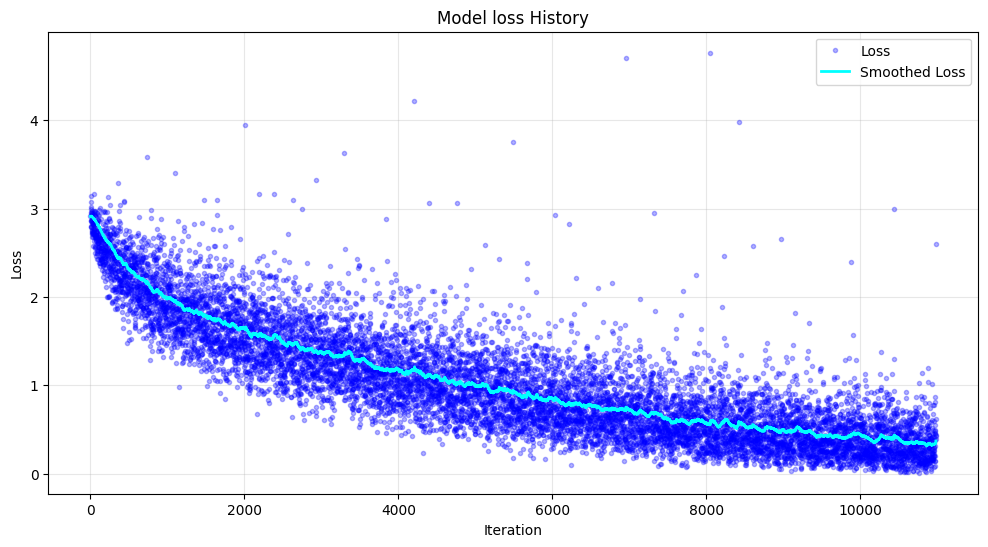

Metric,Minimum,Maximum,Final
Training Loss,0.011204,4.762132,2.594657


In [18]:
plot_losses(_[0],0.01)

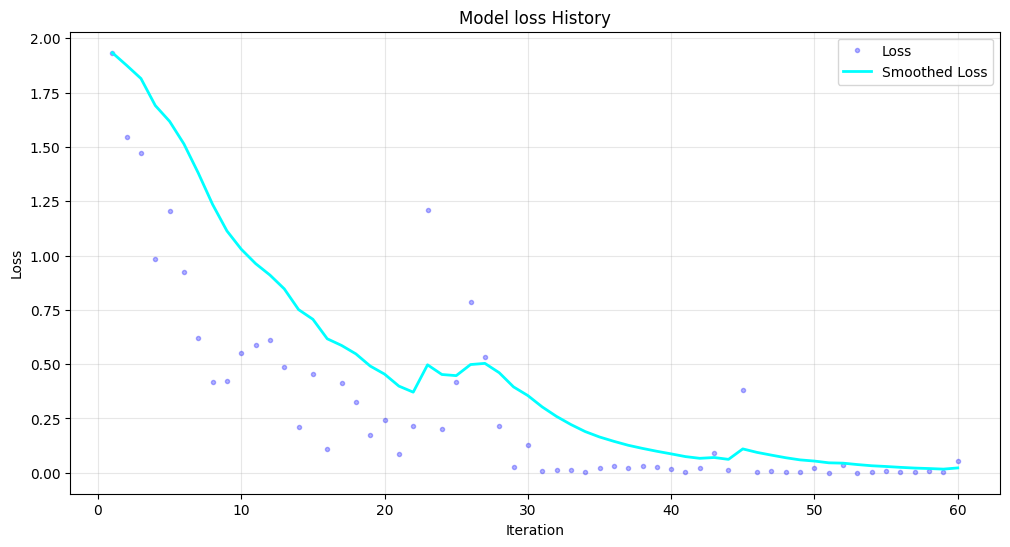

Metric,Minimum,Maximum,Final
Training Loss,0.000160,1.933846,0.053325


In [19]:
plot_losses(_[3],0.15)

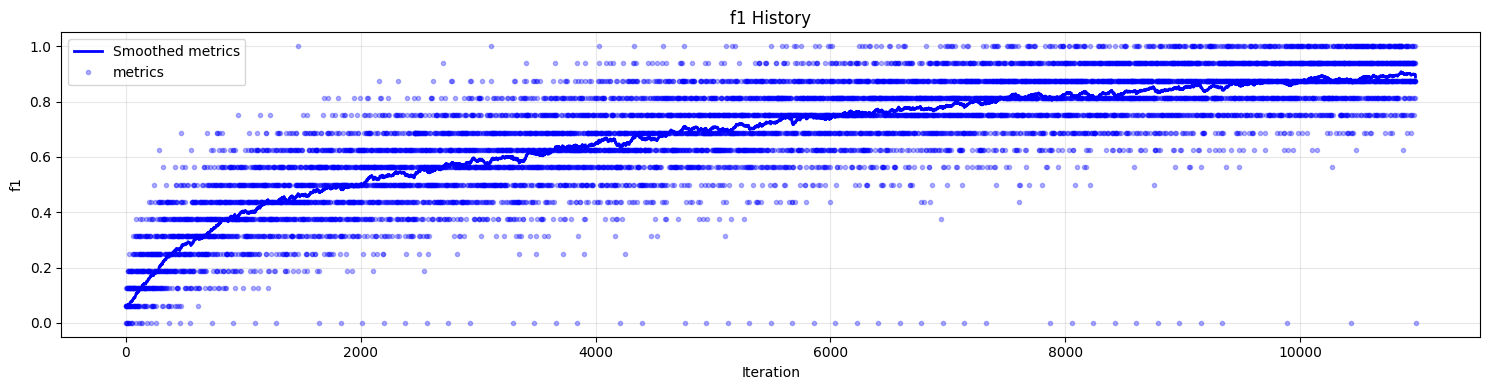

Metric,Minimum,Maximum,Final
Train f1,0.0000,1.0000,0.0000


In [20]:
plot_metrics(_[1], 0.01)

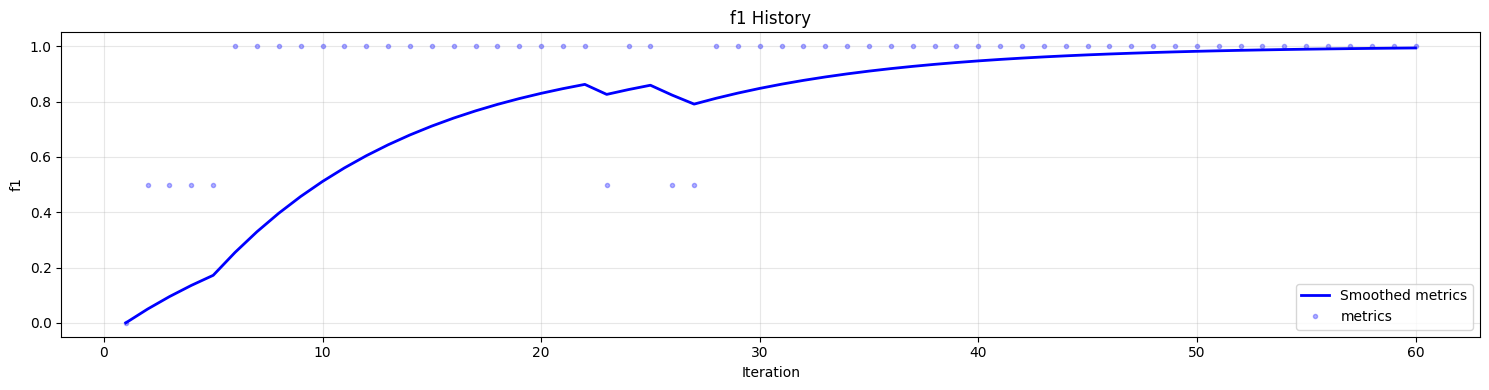

Metric,Minimum,Maximum,Final
Train f1,0.0000,1.0000,1.0000


In [21]:
plot_metrics(_[4])

In [22]:
import torch
from PIL import Image
import numpy as np
from pathlib import Path
from torchvision.io import read_image as ri

def read_image(path):
    path = Path(path)
    image = Image.open(path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_array = np.array(image)
    image_array = np.transpose(image_array, (2, 0, 1))
    image_tensor = torch.from_numpy(image_array)
    return image_tensor

def create_csv(model, path, sample_path = None):
    transform=v2.Compose(
        [
            v2.Resize((128,128)),
            v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    data = pd.read_csv(sample_path)
    l = []
    model.to(device)
    for name in os.listdir(path):
        img = read_image(f"{path}/{name}")
        img = transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        with torch.no_grad():
            model.eval()
            preds = model(img)
            preds = preds.to("cpu")
            l.append((os.path.splitext(name)[0], int(preds.argmax(1).squeeze(0))))

    out = pd.DataFrame(data = l, columns = ["id","label"])
    out.to_csv("subm.csv",index=False)

In [23]:
create_csv(model,"/kaggle/input/one-piece-classification/splitted/test", "/kaggle/input/one-piece-classification/submission.csv")

tensor([15])


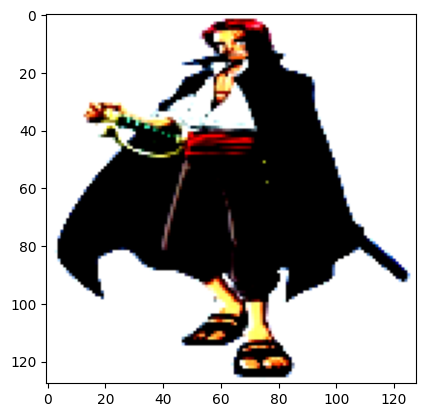

In [24]:
transform=v2.Compose(
        [
            v2.Resize((128,128)),
            v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
img = read_image("/kaggle/input/one-piece-classification/splitted/test/058438ac-f9dd-4375-9029-ad37d3e391dd.png")
img = transform(img)
plt.imshow(img.permute(1, 2, 0))

img = img.unsqueeze(0)
img = img.to("cuda:0")
with torch.no_grad():
    model.eval()
    preds = model(img)
    preds = preds.to("cpu")
    print(preds.argmax(1))

In [25]:
checkpoint = {
    'model_state_dict': model.state_dict(),
}

save = True
if save:
    torch.save(checkpoint, 'state.pth')

In [26]:
# if False:
#     checkpoint = torch.load('/kaggle/input/model1/checkpoint.pth')
#     model.load_state_dict(checkpoint['model_state_dict'])